In [1]:
from tensorflow.keras.preprocessing.image import img_to_array
import cv2 as cv
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

target_image_path = 'amsterdan.jpg'
style_reference_image_path = 'nocheestrellada.jpg'
width, height, _ = cv.imread(target_image_path).shape
img_height = 400
img_width = int(width * img_height / height)

In [2]:
import numpy as np
from tensorflow.keras.applications import vgg19

def preprocess_image(image_path):
    img = cv.imread(image_path)
    img = cv.resize(img,(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [3]:
from tensorflow.keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))

style_reference_image = K.constant(preprocess_image(style_reference_image_path))

combination_image = K.placeholder((1, img_width, img_height, 3))
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image],
                             axis=0)

model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(3, 266, 400, 3)]        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (3, 266, 400, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (3, 266, 400, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (3, 133, 200, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (3, 133, 200, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (3, 133, 200, 128)        147584    
______________________________________________

In [4]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))
def gram_matrix(x):

    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
    
    a = K.square(
    x[:, :img_width - 1, :img_height - 1, :] -
    x[:, 1:, :img_height - 1, :])
    b = K.square(
    x[:, :img_width - 1, :img_height - 1, :] -
    x[:, :img_width - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [5]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
'block2_conv1',
'block3_conv1',
'block4_conv1',
'block5_conv1']
total_variation_weight = 1e-4
style_weight = 0.9
content_weight = 0.05

In [6]:
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features, combination_features)

for layer_name in style_layers:
    
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(style_layers)) * sl
    
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [7]:
grads = K.gradients(loss, combination_image)[0]
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_width, img_height, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
    
evaluator = Evaluator()

In [8]:
from scipy.optimize import fmin_l_bfgs_b
import time

iterations = 30
x = preprocess_image(target_image_path)
x = x.flatten()

for i in range(iterations):
    
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss,
    x,
    fprime=evaluator.grads,
    maxfun=20)
    print('Current loss value:', min_val)
    img = x.copy().reshape((img_width, img_height, 3))
    img = deprocess_image(img)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    
fname = "style_transfer_results/" + target_image_path.split('.')[0] + '_' + style_reference_image_path.split('.')[0] + '.png'
cv.imwrite(fname, img)

Start of iteration 0
Current loss value: 1008356350.0
Iteration 0 completed in 19s
Start of iteration 1
Current loss value: 448933920.0
Iteration 1 completed in 12s
Start of iteration 2
Current loss value: 296589470.0
Iteration 2 completed in 12s
Start of iteration 3
Current loss value: 234971550.0
Iteration 3 completed in 13s
Start of iteration 4
Current loss value: 189621440.0
Iteration 4 completed in 13s
Start of iteration 5
Current loss value: 167500200.0
Iteration 5 completed in 13s
Start of iteration 6
Current loss value: 152488130.0
Iteration 6 completed in 13s
Start of iteration 7
Current loss value: 140841520.0
Iteration 7 completed in 13s
Start of iteration 8
Current loss value: 124038104.0
Iteration 8 completed in 13s
Start of iteration 9
Current loss value: 115293224.0
Iteration 9 completed in 13s
Start of iteration 10
Current loss value: 110778590.0
Iteration 10 completed in 14s
Start of iteration 11
Current loss value: 106225304.0
Iteration 11 completed in 13s
Start of it

True

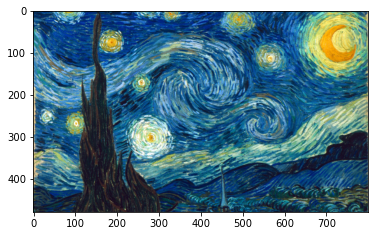

In [9]:
import matplotlib.pyplot as plt

ref = cv.imread(style_reference_image_path)
ref = cv.cvtColor(ref,cv.COLOR_BGR2RGB)
plt.imshow(ref)

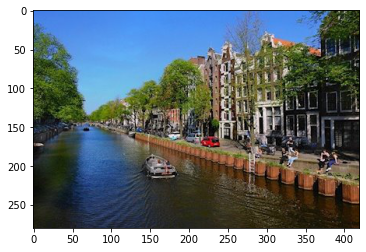

In [10]:
original = cv.imread(target_image_path)
original = cv.cvtColor(original,cv.COLOR_BGR2RGB)
plt.imshow(original)

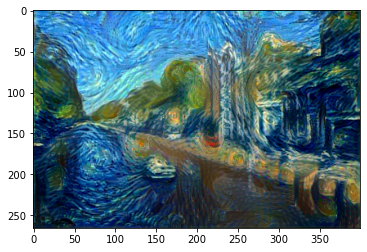

In [11]:
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
plt.imshow(img)